<a href="https://colab.research.google.com/github/jcavalca/breast-cancer-research/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Necessary Packages and Functions

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


### Reading Subtype Dataset

In [2]:
df_subtype = pd.read_csv("BRCA.547.PAM50.SigClust.Subtypes.txt", sep="\t")

In [3]:
df_subtype = df_subtype.set_index("Sample")
df_subtype.rename(columns = {'PAM50':'Subtype'}, inplace = True)

In [4]:
df_subtype.head()

,Type,Siglust,Subtype
Sample,,,
TCGA-AN-A0FL-01A-11R-A034-07,tumor,-13,Basal
TCGA-A1-A0SK-01A-12R-A084-07,tumor,-13,Basal
TCGA-BH-A0HL-01A-11R-A034-07,tumor,-13,Basal
TCGA-BH-A0HN-01A-11R-A084-07,tumor,-13,Basal
TCGA-BH-A0E0-01A-11R-A056-07,tumor,-13,Basal


\### Reading Gene Expression Dataset

In [5]:
df_expression = pd.read_csv("BRCA.exp.547.med.txt", sep="\t").transpose()

In [6]:
genes = df_expression.loc["NAME"]
df_expression = df_expression.drop("NAME")
df_expression.columns = genes

In [7]:
df_expression.head()

NAME,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,ERCC5,GPR98,RXFP3,...,SLC2A11,GRIP2,GPLD1,RAB8A,RXFP2,PIK3IP1,SLC39A6,SNRPD2,AQP7,CTSC
TCGA-A1-A0SD-01A-11R-A115-07,0.220167,0.54375,0.354875,0.4335,1.065167,-0.11225,0.262333,-0.16625,0.322375,-0.496,...,0.308833,-0.00275,0.048,-0.2987,0.0625,-0.1575,0.1907,0.0472,-0.1925,-0.7193
TCGA-A1-A0SE-01A-11R-A084-07,-0.1055,0.0,0.305875,0.03925,0.517,1.31575,0.175333,-0.2975,0.067,0.0085,...,0.214333,0.05975,0.275167,0.2673,-0.0675,0.686,1.5998,-0.0969,-0.546,-0.8805
TCGA-A1-A0SH-01A-11R-A084-07,0.174583,1.3685,0.007,0.2325,1.844667,0.17925,0.6395,-0.05175,-0.47675,-0.138,...,0.027167,-0.02175,-0.2815,0.5805,0.278,0.24475,0.0275,-0.2257,-0.613,-0.491
TCGA-A1-A0SJ-01A-11R-A084-07,0.590083,-0.453,-0.295125,0.66525,-0.530167,0.12225,0.47,-0.02375,-0.421375,0.2545,...,0.483833,0.2475,0.615667,-0.0739,-0.448,0.7325,2.6229,0.3027,2.0545,-0.4711
TCGA-A1-A0SK-01A-12R-A084-07,1.125417,-1.528,0.08275,0.85075,-1.674,-0.849,-1.1125,0.732,0.23375,-0.494,...,-0.640833,0.13075,0.081,0.627,-0.239,-0.26475,-0.9026,-0.0246,-0.564,-0.359


### Merging into a Single Dataset

In [8]:
# dropping genes instead of individuals due to small sample size (dropping individuals almost cut sample in half)
df_combined = df_subtype.merge(df_expression, how="outer", left_index=True, right_index=True).dropna(axis=1)
df_combined.head()

,Type,Siglust,Subtype,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,...,CSF2,SLC2A11,GRIP2,GPLD1,RAB8A,PIK3IP1,SLC39A6,SNRPD2,AQP7,CTSC
TCGA-A1-A0SD-01A-11R-A115-07,tumor,-9,LumA,0.220167,0.54375,0.354875,0.4335,1.065167,-0.11225,0.262333,...,-0.43375,0.308833,-0.00275,0.048,-0.2987,-0.1575,0.1907,0.0472,-0.1925,-0.7193
TCGA-A1-A0SE-01A-11R-A084-07,tumor,-5,LumA,-0.1055,0.0,0.305875,0.03925,0.517,1.31575,0.175333,...,-0.1675,0.214333,0.05975,0.275167,0.2673,0.686,1.5998,-0.0969,-0.546,-0.8805
TCGA-A1-A0SH-01A-11R-A084-07,tumor,-5,LumA,0.174583,1.3685,0.007,0.2325,1.844667,0.17925,0.6395,...,-0.258,0.027167,-0.02175,-0.2815,0.5805,0.24475,0.0275,-0.2257,-0.613,-0.491
TCGA-A1-A0SJ-01A-11R-A084-07,tumor,-3,LumA,0.590083,-0.453,-0.295125,0.66525,-0.530167,0.12225,0.47,...,-0.415,0.483833,0.2475,0.615667,-0.0739,0.7325,2.6229,0.3027,2.0545,-0.4711
TCGA-A1-A0SK-01A-12R-A084-07,tumor,-13,Basal,1.125417,-1.528,0.08275,0.85075,-1.674,-0.849,-1.1125,...,-1.12875,-0.640833,0.13075,0.081,0.627,-0.26475,-0.9026,-0.0246,-0.564,-0.359


### Creating Random Forest Model

In [9]:
X = df_combined.drop(["Type", "Siglust", "Subtype"], axis=1) 
y = df_combined[["Subtype"]]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5) # 70% training and 30% test

In [11]:
model = RandomForestClassifier()
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

### Evaluating Random Forest Model

In [12]:
y_pred = model.predict(X_test)

In [13]:
df_comparison = pd.DataFrame(zip(list(y_test['Subtype']), list(y_pred)), columns=['Actual','Predicted'])
df_comparison.head()

,Actual,Predicted
0,LumA,LumA
1,Basal,Basal
2,LumA,LumA
3,LumA,LumA
4,LumA,LumA


In [14]:
confusion_matrix = pd.crosstab(df_comparison['Actual'], df_comparison['Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,Basal,Her2,LumA,LumB,Normal
Actual,,,,,
Basal,22,1,0,0,0
Her2,0,9,1,7,0
LumA,0,0,77,1,0
LumB,1,0,9,27,0
Normal,0,0,0,1,9


In [15]:
precision_scores = precision_score(list(y_test['Subtype']), list(y_pred), average=None)
precision_scores = [round(i, 2) for i in precision_scores]
recall_scores = recall_score(list(y_test['Subtype']), list(y_pred), average=None)
recall_scores = [round(i, 2) for i in recall_scores]

In [16]:
df_scores = pd.DataFrame(zip(precision_scores, recall_scores, confusion_matrix.columns), columns=['Precision','Recall', 'Class'])
df_scores = df_scores.set_index('Class')
df_scores

,Precision,Recall
Class,,
Basal,0.96,0.96
Her2,0.90,0.53
LumA,0.89,0.99
LumB,0.75,0.73
Normal,1.00,0.90


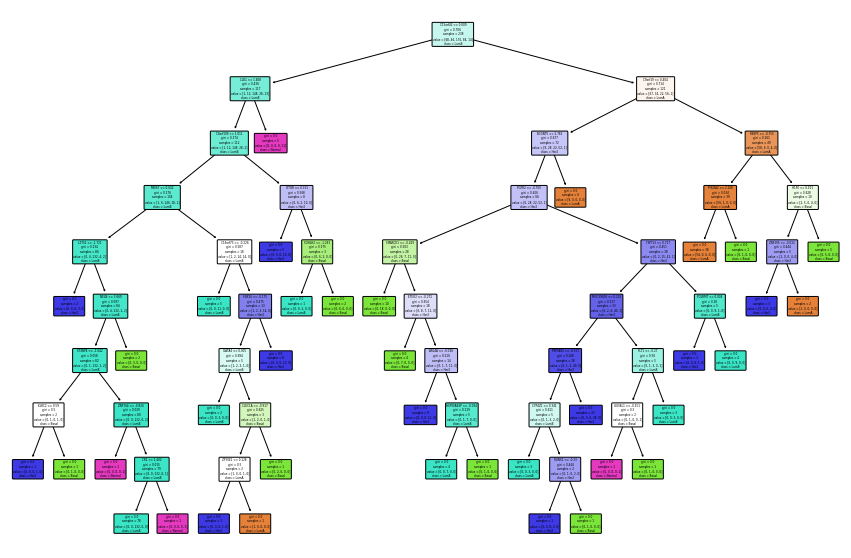

In [17]:
fig = plt.figure(figsize=(15, 10))
plot_tree(model.estimators_[0], 
          feature_names=X.columns,
          class_names=df_combined['Subtype'].unique(), 
          filled=True, rounded=True)

plt.show()

### Genes Importance given by Random Regressor Classifier

In [18]:
model.feature_importances_

array([0.        , 0.        , 0.        , ..., 0.        , 0.00019946,
       0.00010627])

In [19]:
X.columns

Index(['ELMO2', 'CREB3L1', 'RPS11', 'PNMA1', 'MMP2', 'C10orf90', 'ZHX3',
       'ERCC5', 'GPR98', 'RXFP3',
       ...
       'CSF2', 'SLC2A11', 'GRIP2', 'GPLD1', 'RAB8A', 'PIK3IP1', 'SLC39A6',
       'SNRPD2', 'AQP7', 'CTSC'],
      dtype='object', length=17316)

In [20]:
# sorted descending by importance
df_importance = pd.DataFrame(zip(X.columns, list(model.feature_importances_)), columns=["Gene", "Importance"]).set_index("Gene").sort_values(by="Importance", ascending = False)
df_importance.head(20)

,Importance
Gene,
PRR15,0.008377
TBC1D9,0.007615
MLPH,0.007353
FOXM1,0.006646
MCM10,0.006414
CHEK1,0.006150
C15orf42,0.005854
KIF20A,0.005728
ACADSB,0.005268


In [21]:
df_subtype["Subtype"].value_counts()

LumA      232
LumB      129
Basal      98
Her2       58
Normal     30
Name: Subtype, dtype: int64

### Getting and Processing New Dataset

In [22]:
import scipy.io

mat = scipy.io.loadmat("BRCA1View20000.mat")
gene_labels = [g[0] for g in mat['gene'][0]]
df_20000 = pd.DataFrame(mat['data'].transpose(), columns=gene_labels)
# df['id'] = mat['id'][0]
df_20000['target'] = mat['targets']
df_20000['Subtype'] = df_20000.target.map({1:'Basal',2:'HER2+',3:'LumA',4:'LumB',5:'Normal Like',6:'Normal'})
df_20000 = df_20000[df_20000["Subtype"] != "Normal Like"]
df_20000.head()

,SCGB2A2,MUCL1,SCGB1D2,PIP,LOC648852,DNAJA2,TFF3,S100P,CPB1,CEACAM6,...,LOC645307,IL1RAP,LOC647149,LOC642453,LOC652100,LOC646050,LOC644912,LOC652294,target,Subtype
0,6.365374,5.610561,5.134799,5.735802,5.855315,5.443985,8.005882,5.615179,6.682096,5.756946,...,5.420998,5.396492,5.358751,5.424770,5.411055,5.242460,5.197767,5.643537,6,Normal
1,14.330442,7.979139,10.244240,7.138279,9.890661,11.195867,13.511164,10.548596,5.491578,6.805606,...,5.167652,5.273045,5.287980,5.398061,5.226934,5.396744,5.352158,5.811813,4,LumB
2,14.388331,6.016715,12.164435,5.272691,6.468386,5.265518,13.386034,8.764722,7.331663,11.967719,...,5.327874,5.549589,5.333051,5.368544,5.296182,5.694022,5.459744,5.269015,4,LumB
4,12.243103,7.293489,10.919581,9.566137,8.503568,11.492583,11.531352,9.818938,9.443134,6.889670,...,5.487783,5.479967,5.332074,5.273141,5.282872,5.222482,5.186136,5.616094,3,LumA
5,12.805814,5.988130,10.158678,8.014498,7.969488,5.153460,14.464282,6.916060,7.431630,8.414641,...,5.382077,5.486193,5.032729,5.363865,5.165766,5.476541,5.257098,5.530484,2,HER2+


In [23]:
def subtypeMapping(subtype):
  if subtype == "HER2+":
    return "Her2"
  return subtype

In [24]:
df_20000["Subtype"] = df_20000["Subtype"].map(subtypeMapping)

In [25]:
genes_in_common = set(list(df_combined.columns)).intersection(set(list(df_20000.columns)))
df_combined_drop_columns = set(df_combined.columns[3:]) - genes_in_common
df_20000_drop_columns = set(df_20000.columns[:-2]) - genes_in_common
len(genes_in_common)

14833

In [26]:
df_combined_common_genes = df_combined.drop(df_combined_drop_columns, axis=1)
df_20000_common_genes = df_20000.drop(df_20000_drop_columns, axis=1)

In [27]:
df_combined_common_genes.head(2)

,Type,Siglust,Subtype,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,...,HCLS1,CSF2,SLC2A11,GPLD1,RAB8A,PIK3IP1,SLC39A6,SNRPD2,AQP7,CTSC
TCGA-A1-A0SD-01A-11R-A115-07,tumor,-9,LumA,0.220167,0.54375,0.354875,0.4335,1.065167,-0.11225,0.262333,...,-0.554667,-0.43375,0.308833,0.048,-0.2987,-0.1575,0.1907,0.0472,-0.1925,-0.7193
TCGA-A1-A0SE-01A-11R-A084-07,tumor,-5,LumA,-0.1055,0.0,0.305875,0.03925,0.517,1.31575,0.175333,...,-0.412333,-0.1675,0.214333,0.275167,0.2673,0.686,1.5998,-0.0969,-0.546,-0.8805


In [28]:
df_20000_common_genes.head()

,SCGB2A2,MUCL1,SCGB1D2,PIP,DNAJA2,TFF3,S100P,CPB1,CEACAM6,SCGB2A1,...,FBXO25,MLANA,DAB1,C2orf19,NSL1,SYT5,C10orf62,IL1RAP,target,Subtype
0,6.365374,5.610561,5.134799,5.735802,5.443985,8.005882,5.615179,6.682096,5.756946,5.444719,...,5.475921,5.058263,5.178206,5.105706,6.284404,5.616339,5.245275,5.396492,6,Normal
1,14.330442,7.979139,10.244240,7.138279,11.195867,13.511164,10.548596,5.491578,6.805606,10.942782,...,5.554798,5.220061,4.974619,5.486211,6.358165,5.453547,5.450314,5.273045,4,LumB
2,14.388331,6.016715,12.164435,5.272691,5.265518,13.386034,8.764722,7.331663,11.967719,12.690971,...,5.849457,5.245774,5.241753,5.759466,6.129600,5.861127,5.319894,5.549589,4,LumB
4,12.243103,7.293489,10.919581,9.566137,11.492583,11.531352,9.818938,9.443134,6.889670,8.416175,...,5.243130,5.296567,5.230233,5.283717,6.357914,5.458864,5.100869,5.479967,3,LumA
5,12.805814,5.988130,10.158678,8.014498,5.153460,14.464282,6.916060,7.431630,8.414641,8.753603,...,5.729262,5.433647,5.391205,5.341332,6.414287,5.505140,5.309892,5.486193,2,Her2


### Training and Evaluating Different Models

#### Built-in Scalers


In [62]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline

X_train = df_combined_common_genes.drop(["Type", "Siglust", "Subtype"], axis=1)
X_train.columns = X_test.columns.map(str)
feature_names_order = X_train.columns
y_train = df_combined_common_genes["Subtype"]

# define pipeline and fit to training set
pipeline_std = make_pipeline(
          StandardScaler(),
          RandomForestClassifier()
)

pipeline_max_abs = make_pipeline(
          MaxAbsScaler(),
          RandomForestClassifier()
)

pipeline_min_max = make_pipeline(
          MinMaxScaler(),
          RandomForestClassifier()
)

pipeline_std.fit(X=X_train, y=y_train)
pipeline_max_abs.fit(X=X_train, y=y_train)
pipeline_min_max.fit(X=X_train, y=y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [63]:
X_test = df_20000_common_genes.drop(["target", "Subtype"], axis=1)
y_test = df_20000_common_genes["Subtype"]
X_test.columns = X_test.columns.map(str) # fixing warnign of non-str feature name
X_test = X_test[feature_names_order]

In [65]:
y_pred_std = pipeline_std.predict(X_test)
y_pred_max_abs = pipeline_max_abs.predict(X_test)
y_pred_min_max = pipeline_min_max.predict(X_test)

In [66]:
# StandardScaler

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_std, digits=2, zero_division=False))

              precision    recall  f1-score   support

       Basal       0.00      0.00      0.00       330
        Her2       0.12      1.00      0.22       239
        LumA       0.00      0.00      0.00       721
        LumB       0.00      0.00      0.00       491
      Normal       0.00      0.00      0.00       150

    accuracy                           0.12      1931
   macro avg       0.02      0.20      0.04      1931
weighted avg       0.02      0.12      0.03      1931



In [67]:
# MaxAbsScaler

print(classification_report(y_test, y_pred_max_abs, digits=2, zero_division=False))

              precision    recall  f1-score   support

       Basal       0.00      0.00      0.00       330
        Her2       0.12      1.00      0.22       239
        LumA       0.00      0.00      0.00       721
        LumB       0.00      0.00      0.00       491
      Normal       0.00      0.00      0.00       150

    accuracy                           0.12      1931
   macro avg       0.02      0.20      0.04      1931
weighted avg       0.02      0.12      0.03      1931



In [68]:
# MinMaxScaler

print(classification_report(y_test, y_pred_min_max, digits=2, zero_division=False))

              precision    recall  f1-score   support

       Basal       0.00      0.00      0.00       330
        Her2       0.00      0.00      0.00       239
        LumA       0.00      0.00      0.00       721
        LumB       0.25      1.00      0.41       491
      Normal       0.00      0.00      0.00       150

    accuracy                           0.25      1931
   macro avg       0.05      0.20      0.08      1931
weighted avg       0.06      0.25      0.10      1931



#### Other Scalers


In [98]:
# Normalization by library size (total reads)

X_test_library_size = X_test.div(X_test.sum(axis=1), axis='rows')
y_test = df_20000_common_genes["Subtype"]
X_train_library_size = X_train.div(X_train.sum(axis=1), axis='rows')
y_train = df_combined_common_genes["Subtype"]

In [99]:
model = RandomForestClassifier()
model.fit(X_train_library_size, y_train)
y_pred = model.predict(X_test_library_size)

In [100]:
print(classification_report(y_pred, y_test, digits=2, zero_division=False))

              precision    recall  f1-score   support

       Basal       0.00      0.00      0.00         0
        Her2       0.00      0.00      0.00         0
        LumA       1.00      0.37      0.54      1931
        LumB       0.00      0.00      0.00         0
      Normal       0.00      0.00      0.00         0

    accuracy                           0.37      1931
   macro avg       0.20      0.07      0.11      1931
weighted avg       1.00      0.37      0.54      1931

